## Nolan Greth
## 12/4/21
## GEO 391 Project

<h1><center>Using a Neural Network to Estimate Shear Wave Velocity based on SPT Data</center></h1>

Using the power law relationship: 
<h1><center>$ln(Vs) = a + bln(N)$</center></h1>

In [1]:
# importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import os #operating system. used to interact with and navigate through directories
import pandas as pd
import sklearn
import seaborn as sns                           # For matrix scatter plots
from scipy import stats                         # Summary statistics and statistical methods

### Data Processing

In [2]:
# Loading data

#edit to the directory that holds your spreadsheet
os.chdir(r'C:\Users\ngret\Downloads\GEO ML\Project')

#Reading the raw blow count and shear wave velocity data into a pandas dataframe
df = pd.read_csv("data.csv")
del df['Unnamed: 7']
del df['Unnamed: 8']
del df['Reference']

#Print the first 5 rows
df.head()

,Data No.,Region No.,Region,N,Vs (m/s),Soil type
0,1,1,"North Florida, US",1.0,65.3,unknown
1,2,1,"North Florida, US",1.0,75.0,unknown
2,3,1,"North Florida, US",1.0,84.6,unknown
3,4,1,"North Florida, US",1.0,90.1,unknown
4,5,1,"North Florida, US",1.0,103.8,unknown


In [3]:
# Search for nans

nan_index_new = df.isna()
print(nan_index_new.sum())

Data No.      0
Region No.    0
Region        0
N             0
Vs (m/s)      0
Soil type     0
dtype: int64


In [4]:
# Separating blow count and shear wave velocity data by region:

Regions = pd.DataFrame(df.Region.unique())

lnN = []
lnVs = []

boxes = [0] * np.size(Regions)

for i in np.arange(0,16):
    lnN.append(boxes[i])
    lnN[i] = np.log(df.loc[df['Region'] == Regions[0][i]]['N'].values)
    lnVs.append(boxes[i])
    lnVs[i] = np.log(df.loc[df['Region'] == Regions[0][i]]['Vs (m/s)'].values)

print(Regions)

                                 0
0                North Florida, US
1   Southern San Francisco Bay, US
2                      Madison, US
3                           Greece
4                Caspian Sea, Iran
5           Yenisehir town, Turkey
6                Eskisehir, Turkey
7                    Erbaa, Turkey
8                     Delhi, India
9                   Chennai, India
10                   Kanpur, India
11                  Roorkee, India
12                  Dholera, India
13              Jakarta, Indonesia
14                   Molise, Italy
15         Kathmandu Valley, Nepal


## Preparing the data for use in the model - scaling data

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [6]:
# Scale data to ensure features are normally distributed
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
# Define loss function
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [7]:
columns = ["N", "Vs (m/s)"]
regiondata = []
sregiondata_t = []
dataset = []
mean = []
std = []

for i in np.arange(0,16):
    regiondata.append(boxes[i])
    sregiondata_t.append(boxes[i])
    dataset.append(boxes[i])
    mean.append(boxes[i])
    std.append(boxes[i])
    regiondata[i] = df.loc[df['Region No.'] == i+1]
    regiondata[i] = np.log(regiondata[i][columns].dropna(axis=0))
    mean[i] = np.mean(regiondata[i])
    sregiondata_t[i] = regiondata[i] - mean[i]
    std[i] = np.std(sregiondata_t[i])
    sregiondata_t[i] = sregiondata_t[i]/std[i]
    dataset[i] = pd.DataFrame(sregiondata_t[i], columns=columns)


In [8]:
inputs = ["N"]
outputs = ["Vs (m/s)"]
n_samples = []
batch_size = []
buffer_size = []
n_train = []

for i in np.arange(0,16):
    n_samples.append(boxes[i])
    batch_size.append(boxes[i])
    buffer_size.append(boxes[i])
    n_train.append(boxes[i])
    n_epochs = 100
    n_samples[i] = len(dataset[i])
    n_batches = 4
    batch_size[i] = np.floor(n_samples[i]/n_batches)
    buffer_size[i] = n_samples[i]
    n_train[i] = int(0.7*len(dataset[i]))

In [9]:
data1 = []
data_train = []
data_test = []

for i in np.arange(0,16):
    data1.append(boxes[i])
    data_train.append(boxes[i])
    data_test.append(boxes[i])
    data1[i] = tf.data.Dataset.from_tensor_slices((dataset[i][inputs].values, dataset[i][outputs].values))
    data1[i] = data1[i].shuffle(n_samples[i], reshuffle_each_iteration=True)
    data_train[i] = data1[i].take(n_train[i]).batch(batch_size[i]).repeat(n_epochs)
    data_test[i] = data1[i].skip(n_train[i]).batch(1)

## Building the Bayesian Neural Network Model

In [10]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

In [11]:
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

model.compile(optimizer="adam", loss=neg_log_likelihood)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                20        
                                                                 
 distribution_weights (Dense  (None, 2)                22        
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 1),              0         
 riL)                         (None, 1))                         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [12]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

### Simulating trials using a Monte Carlo Simulation

In [13]:
samples = []
iterations = 10
test_iterator = []
X_true = []
Y_true = []
Y_pred = []
Y_predm = []
Y_predstd = []
Y_predplusstd = []
Y_predminusstd = []

for i in np.arange(0,16):
    samples.append(boxes[i])
    samples[i] = len(data_test[i])
    model.fit(data_train[i], epochs=n_epochs, validation_data=data_test[i], verbose=False)
    test_iterator.append(boxes[i])
    test_iterator[i] = tf.compat.v1.data.make_one_shot_iterator(data_test[i])
    X_true.append(boxes[i])
    Y_true.append(boxes[i])
    Y_pred.append(boxes[i])
    Y_predm.append(boxes[i])
    Y_predstd.append(boxes[i])
    Y_predplusstd.append(boxes[i])
    Y_predminusstd.append(boxes[i])
    X_true[i], Y_true[i], Y_pred[i], Y_predm[i], Y_predstd[i], Y_predplusstd[i], Y_predminusstd[i] = np.empty(shape=(samples[i], len(inputs))), np.empty(shape=(samples[i], len(outputs))), np.empty(shape=(samples[i], len(outputs), iterations)),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs)))
    for s in range(samples[i]):
        features, labels = test_iterator[i].get_next()
        X_true[i][s,:] = features
        Y_true[i][s,:] = labels.numpy()
        for k in range(iterations):
            Y_pred[i][s,:,k] = model.predict(features)
        Y_predm[i][s,:] = np.mean(Y_pred[i][s,:,:])
        Y_predstd[i][s,:] = np.std(Y_pred[i][s,:,:])
        Y_predplusstd[i][s,:] = Y_predm[i][s,:] + (2*Y_predstd[i][s,:])
        Y_predminusstd[i][s,:] = Y_predm[i][s,:] - (2*Y_predstd[i][s,:])

## Fitting a line to the predictions with linear regression - rescaling the data

In [14]:
from sklearn import linear_model
Vsmean1 = []
Y_pred_plus2s = []
Y_pred_minus2s = []
sVsmean1 = []
sY_pred_plus2s = []
sY_pred_minus2s = []
sX_true = []
sY_true = []


for i in np.arange(0,16):
    Vsmean1.append(boxes[i])
    Y_pred_plus2s.append(boxes[i])
    Y_pred_minus2s.append(boxes[i])
    sVsmean1.append(boxes[i])
    sY_pred_plus2s.append(boxes[i])
    sY_pred_minus2s.append(boxes[i])
    sX_true.append(boxes[i])
    sY_true.append(boxes[i])

    regr1 = linear_model.LinearRegression() #Linear regression object
    regr2 = linear_model.LinearRegression()
    regr3 = linear_model.LinearRegression()
    
    regr1.fit(X_true[i],Y_predm[i])
    Vsmean1[i] = regr1.predict(np.array(dataset[i]['N']).reshape(-1, 1))
    sVsmean1[i] = (((Vsmean1[i])*std[i][1])+mean[i][1])

    regr2.fit(X_true[i],Y_predplusstd[i])
    Y_pred_plus2s[i]=regr2.predict(np.array(dataset[i]['N']).reshape(-1, 1))
    sY_pred_plus2s[i] = (((Y_pred_plus2s[i])*std[i][1])+mean[i][1])
    
    regr3.fit(X_true[i],Y_predminusstd[i])
    Y_pred_minus2s[i]=regr3.predict(np.array(dataset[i]['N']).reshape(-1, 1))
    sY_pred_minus2s[i] = (((Y_pred_minus2s[i])*std[i][1])+mean[i][1])
    
    sX_true[i] = (((X_true[i])*std[i][0])+mean[i][0])
    sY_true[i] = (((Y_true[i])*std[i][1])+mean[i][1])
     

## Comparing the BNN predications to the actual data

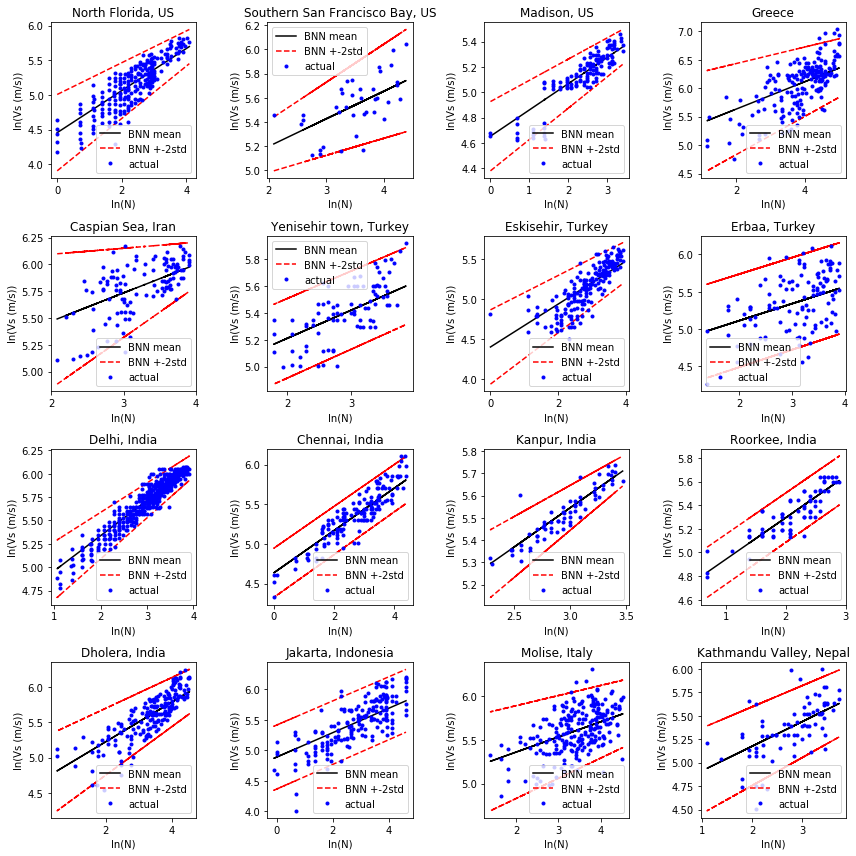

In [15]:
# After Scaling

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
size = 7

for i in np.arange(0,16):
    plt.subplot(4, 4, i+1)
    plt.plot(lnN[i],sVsmean1[i],'k', label= "BNN mean")
    plt.plot(lnN[i],sY_pred_plus2s[i],'r', linestyle='dashed', label= "BNN +-2std")
    plt.plot(lnN[i],sY_pred_minus2s[i],'r', linestyle='dashed')
    plt.plot(lnN[i],lnVs[i],'b.', label= "actual")
    plt.title(Regions[0][i])
    plt.ylabel('ln(Vs (m/s))')
    plt.xlabel('ln(N)')
    plt.legend()

plt.tight_layout()
plt.show()

## Importing the Hiearchical Bayesian Model from Xiao et. al (2021)

In [16]:
# HBM Predictions

#Reading the HBM results into a pandas dataframe
dfHBM = pd.read_csv("data_HBMresults.csv")
dfHBM.head()

lnVsHBM = []
corrcoefHBM = []
boxes = [0] * np.size(Regions)

for i in np.arange(0,16):
    lnVsHBM.append(boxes[i])
    corrcoefHBM.append(boxes[i])
    lnVsHBM[i] = ((dfHBM.loc[dfHBM['Region'] == Regions[0][i]]['a_mean'].values)+((dfHBM.loc[dfHBM['Region'] == Regions[0][i]]['b_mean'].values)*lnN[i]))

## Comparing the fit of BNN and HBM data using R2

In [88]:
# Estimating the fit of the NN and HBM model using the (coefficient of determination) regression score function

R2NN = []
R2HBM = []

for i in np.arange(0,16):
    R2NN.append(boxes[i])
    R2HBM.append(boxes[i])
    R2NN[i] = sklearn.metrics.r2_score(lnVs[i],sVsmean1[i])
    R2HBM[i] = sklearn.metrics.r2_score(lnVs[i],lnVsHBM[i])

In [92]:
np.mean(R2HBM) - np.mean(R2NN)

0.026957557927856257

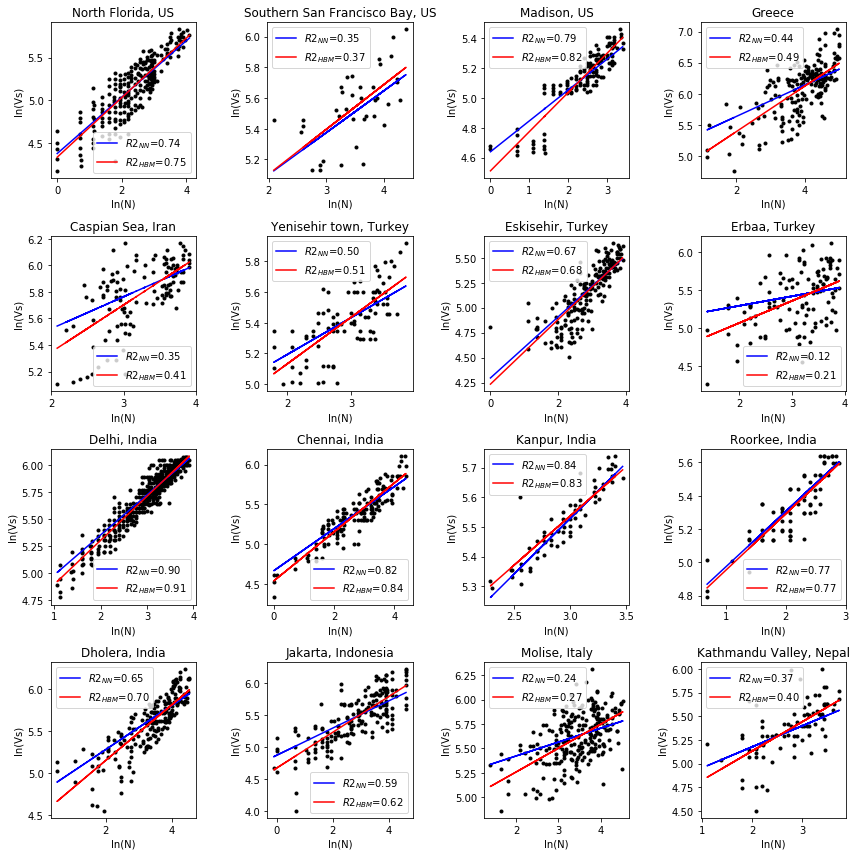

In [89]:
#Comparing raw data, HBM estimates, and NN estimates

plt.figure(figsize=(12, 12))
size = 7

for i in np.arange(0,16):
    plt.subplot(4, 4, i+1)
    plt.plot(lnN[i],lnVs[i],'k.')
#    plt.plot(lnN[i],lnVs_predict[i][:,0].T, 'b-', label= "$\u03C1_{NN}$" "=%.2f" %corrcoefNN[i])
    plt.plot(lnN[i],sVsmean1[i],'b-', label= "$R2_{NN}$" "=%.2f" %R2NN[i])
    plt.plot(lnN[i],lnVsHBM[i], 'r-', label="$R2_{HBM}$" "=%.2f" %R2HBM[i])
    plt.title(Regions[0][i])
    plt.ylabel('ln(Vs)')
    plt.xlabel('ln(N)')
    plt.legend()

plt.tight_layout()
plt.show()

## North Florida training on limited amount of data

In [90]:
import array as arr
datapoints = np.array(['n = 5','n = 10','n = 20','n = 40','n = 80'])
datapointsz = np.array([5,10,20,40,80])
datapointsname = pd.DataFrame(datapoints)
datapointsname[0][0]

'n = 5'

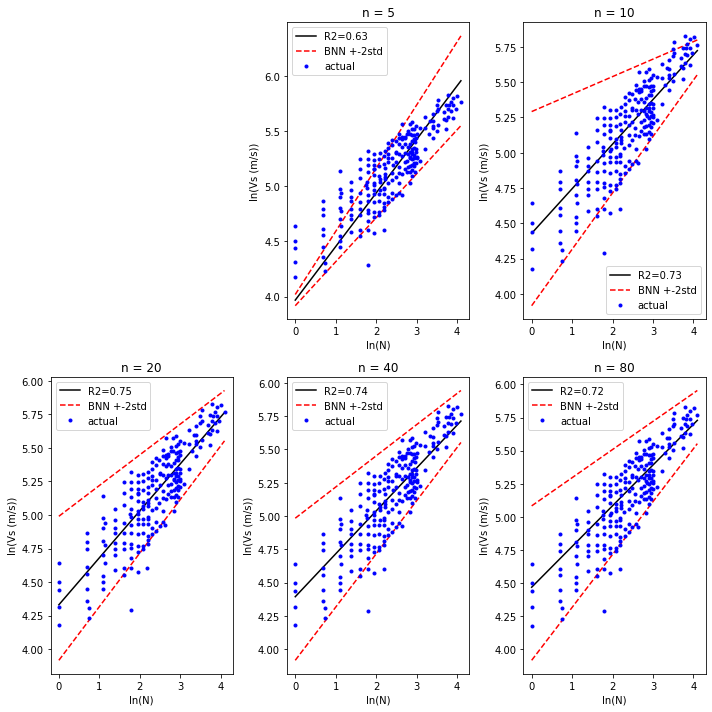

In [91]:
import array as arr

plt.figure(figsize=(10, 10))
size = 5

sVsmean1d = []
sY_pred_plus2sd = []
sY_pred_minus2sd = []
data1d = []
data_traind = []
data_testd = []
R2d = []

for i in np.arange(0,5):
    data1d.append(boxes[i])
    data_traind.append(boxes[i])
    data_testd.append(boxes[i])
    sVsmean1d.append(boxes[i])
    sY_pred_plus2sd.append(boxes[i])
    sY_pred_minus2sd.append(boxes[i])
    R2d.append(boxes[i])
    n_samples[0] = len(dataset[0])
    batch_size[0] = np.floor(n_samples[0]/n_batches)
    buffer_size[0] = n_samples[0]
    n_train[i] = int(0.7*len(dataset[i]))
    data1d[i] = tf.data.Dataset.from_tensor_slices((dataset[0][inputs].values, dataset[0][outputs].values))
    data1d[i] = data1d[i].shuffle(n_samples[0], reshuffle_each_iteration=True)
    data_traind[i] = data1d[i].take(n_train[i]).batch(batch_size[0]).repeat(n_epochs)
    data_testd[i] = data1d[i].skip(n_train[i]).batch(1)
#    samples[i] = len(data_testd[i])
    samples[i] = datapointsz[i]
    model.fit(data_traind[i], epochs=n_epochs, validation_data=data_testd[i], verbose=False)
    test_iterator[i] = tf.compat.v1.data.make_one_shot_iterator(data_testd[i])
    X_true[i], Y_true[i], Y_pred[i], Y_predm[i], Y_predstd[i], Y_predplusstd[i], Y_predminusstd[i] = np.empty(shape=(samples[i], len(inputs))), np.empty(shape=(samples[i], len(outputs))), np.empty(shape=(samples[i], len(outputs), iterations)),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs))),  np.empty(shape=(samples[i], len(inputs)))
    for s in range(samples[i]):
        features, labels = test_iterator[i].get_next()
        X_true[i][s,:] = features
        Y_true[i][s,:] = labels.numpy()
        for k in range(iterations):
            Y_pred[i][s,:,k] = model.predict(features)
        Y_predm[i][s,:] = np.mean(Y_pred[i][s,:,:])
        Y_predstd[i][s,:] = np.std(Y_pred[i][s,:,:])
        Y_predplusstd[i][s,:] = Y_predm[i][s,:] + (2*Y_predstd[i][s,:])
        Y_predminusstd[i][s,:] = Y_predm[i][s,:] - (2*Y_predstd[i][s,:])
    regr1 = linear_model.LinearRegression() #Linear regression object
    regr2 = linear_model.LinearRegression()
    regr3 = linear_model.LinearRegression()
    
    regr1.fit(X_true[i],Y_predm[i])
    Vsmean1[i] = regr1.predict(np.array(dataset[0]['N']).reshape(-1, 1))
    sVsmean1d[i] = (((Vsmean1[i])*std[0][1])+mean[0][1])

    regr2.fit(X_true[i],Y_predplusstd[i])
    Y_pred_plus2s[i]=regr2.predict(np.array(dataset[0]['N']).reshape(-1, 1))
    sY_pred_plus2sd[i] = (((Y_pred_plus2s[i])*std[0][1])+mean[0][1])
    
    regr3.fit(X_true[i],Y_predminusstd[i])
    Y_pred_minus2s[i]=regr3.predict(np.array(dataset[0]['N']).reshape(-1, 1))
    sY_pred_minus2sd[i] = (((Y_pred_minus2s[0])*std[0][1])+mean[0][1])
    
    sX_true[i] = (((X_true[i])*std[0][0])+mean[0][0])
    sY_true[i] = (((Y_true[i])*std[0][1])+mean[0][1])
    
    R2d[i] = sklearn.metrics.r2_score(lnVs[0],sVsmean1d[i])
    
    plt.subplot(2, 3, i+2)
    plt.plot(lnN[0],sVsmean1d[i],'k', label= "R2" "=%.2f" %R2d[i])
    plt.plot(lnN[0],sY_pred_plus2sd[i],'r', linestyle='dashed', label= "BNN +-2std")
    plt.plot(lnN[0],sY_pred_minus2sd[i],'r', linestyle='dashed')
    plt.plot(lnN[0],lnVs[0],'b.', label= "actual")
    plt.title(datapointsname[0][i])
    plt.ylabel('ln(Vs (m/s))')
    plt.xlabel('ln(N)')
    plt.legend()
    
plt.tight_layout()
plt.show()